This script allows to plot the ERAI and CESM topography in form of a surface pressure.

In [1]:
import numpy as np
import pandas as pd
import dypy.netcdf as dn
from dypy.plotting import Mapfigure
import matplotlib.pyplot as plt
import os
import re

# Import constants from constants.py file in directory above
import sys
sys.path.append("..")
from constants import *

# Define plotting style
plt.rcParams.update({'font.size': 20, 'figure.figsize': (16,9)})

--- Avaliable variables ---
Base directory: BASE_DIR
Bounding box coordinates: LON_MIN, LON_MAX, LAT_MIN, LAT_MAX
ERAI coordinates: LONS_ERA, LATS_ERA
CESM coordinates: LONS_CESM, LATS_CESM
CESM slice: INDEX_CESM
CESM coordinates for plotting (string): LONS_CESM_STRING, LATS_CESM_STRING


# Make figure with grid coordinates

Saved figure at: /net/litho/atmosdyn2/chmony/develop/FoehnDevelopment/figures/CESM_grid_points.pdf


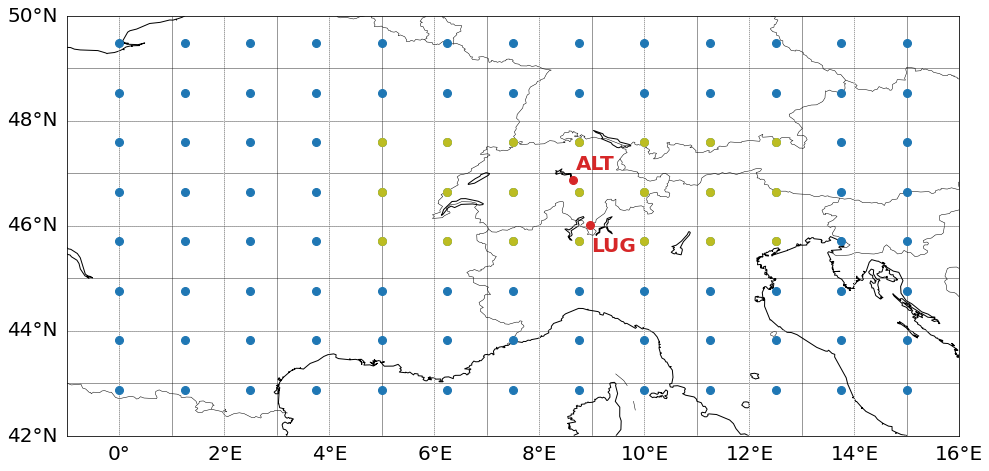

In [2]:
# Create figure with map of bounding box
mf = Mapfigure(lon=np.array([LON_MIN-1,LON_MAX+1]), lat=np.array([LAT_MIN, LAT_MAX]))
mf.drawmap(nbrem=2, nbrep=2, meridiansargs={"color":"w"}, parallelsargs={"color": "w"})

# Create a meshgrid with all points
X = np.array([[x,y] for x in LONS_CESM for y in LATS_CESM])
plt.plot(X[:,0], X[:,1],"o", color="tab:blue", markersize=8 ,alpha=1)

# Plot the points which are excluded later in different color
X = np.array([[x,y] for x in LONS_CESM[4:11] for y in LATS_CESM[3:6]])
plt.plot(X[:,0], X[:,1], "o", color="tab:olive", markersize=8)

# Plot Altdorf and Lugano locations
color="tab:red"
plt.plot(8.64441, 46.88042, 'o', color=color,markersize=8)
plt.text(8.7, 46.99,'ALT',horizontalalignment='left', verticalalignment="bottom", color=color, weight="bold")
plt.plot(8.96004, 46.01008, 'o', color=color,markersize=8)
plt.text(8.99, 45.8,'LUG',horizontalalignment='left', verticalalignment="top", color=color, weight="bold")

# Add grid lines of full degrees (each intersection resembles ERAI grid point)
for x_pos in range(0,16):
    plt.vlines(x_pos, 42,50, linewidth=0.8, alpha=0.5)
for y_pos in range(43,50):
    plt.hlines(y_pos, -1,16, linewidth=0.8, alpha=0.5)

plt.savefig(os.path.join(BASE_DIR, "figures/CESM_grid_points.pdf"), bbox_inches='tight', dpi=200)
print(f"Saved figure at: {os.path.join(BASE_DIR, 'figures/CESM_grid_points.pdf')}")

# Make ERAI and CESM topography plot

## Read ERAI data

In [3]:
# Get all file of for one year of ERAI data (1991 in this case)
rootdir = "/net/bio/atmosdyn/erainterim/cdf/1991/"
relevant_file_paths = []
for root, subdirs, files in os.walk(rootdir):
    if len(root.split("/")) == 8:  # Only take the lowest subdir (where the files are)
        relevant_file_paths_local = [os.path.join(root, netcdf_file) for netcdf_file in files if re.compile('P\w+').match(netcdf_file) ] # Filter for the "P..." files
        relevant_file_paths.extend(relevant_file_paths_local)
print("Relevant files: ", len(relevant_file_paths))

Relevant files:  1460


In [4]:
# Define empty grid
PS_ERA = np.zeros((LAT_MAX-LAT_MIN+1, LON_MAX-LON_MIN+1))

# Loop over all files from cell before
for i, file_path in enumerate(relevant_file_paths):
    print(i, end="\r", flush=True)
    PS, = dn.read_var(file_path, ['PS'])  # Read surface pressure
    PS_cut = PS[(LAT_MIN+90):(LAT_MAX+90+1),(180+LON_MIN):(180+LON_MAX+1)]  # Cut out correct coordinates
    PS_ERA += PS_cut
    
PS_ERA = PS_ERA/len(relevant_file_paths)  # Create average surface pressure

## Read CESM data

In [5]:
filepath = f"/net/litho/atmosdyn/INTEXseas/cesm/cesm112_LENS/b.e112.B20TRLENS.f09_g16.ethz.001/archive/atm/hist/b.e112.B20TRLENS.f09_g16.ethz.001.cam.h1.1991-01-02-00000.nc"
PS_CESM =  np.array(dn.read_var(filepath, ["PS"], index=INDEX_CESM))[0].mean(axis=0)/100  # Select surface level pressure within given frame and average (division through 100 is due to Pa-hPa conversion)

## Plot ERAI and CESM data

In [6]:
def make_mapfigure(PS_grid, LONS, LATS):
    """
    Make a topography plot for ERAI or CESM.
    @param PS_grid: Surface level pressures on grid in given box. 
    @param LONS: Longitude values for contour plot.
    @param LATS: Latitude values for contour plot.
    """
    
    # Define plotting relevant variables
    vmin = 850
    vmax = 1035
    levels = np.arange(vmin, vmax, 10)
    cmap = plt.cm.get_cmap('terrain_r')
    color = "black"
    
    # Add mapfigure with lat/lon lines
    mf = Mapfigure(lon=np.array(LONS_CESM), lat=np.array(LATS_CESM))
    mf.drawmap(nbrem=1, nbrep=1)

    # Make contour plot
    cnt = plt.contourf(LONS, LATS, PS_grid, levels, cmap=cmap, vmin=vmin, vmax=vmax)

    # Make colorbar pretty
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(PS_grid)
    m.set_clim(vmin, vmax)
    cbar = plt.colorbar(m, boundaries=levels, ticks=levels[1::2], extend="both", fraction=0.0188, pad=0.03)
    cbar.set_label("hPa", rotation=90, labelpad=10)

    # Draw dotted black frame
    plt.plot([3.75,13.75],[44.76,44.76],":", color=color, linewidth=3)
    plt.plot([3.75,13.75],[48.53,48.53],":", color=color, linewidth=3)
    plt.plot([3.75,3.75],[44.76,48.53],":", color=color, linewidth=3)
    plt.plot([13.75,13.75],[44.76,48.53],":", color=color,linewidth=3)

    # Plot location of Altdorf and Lugano
    plt.plot(8.64441, 46.88042, 'o', color="w", markersize=8)
    plt.text(8.1, 47.01,'ALT',horizontalalignment='left', verticalalignment="bottom", color="w", weight="bold")
    plt.plot(8.96004, 46.01008, 'o', color="w", markersize=8)
    plt.text(9.1, 46.05,'LUG',horizontalalignment='left', verticalalignment="top", color="w", weight="bold")

Saved figure at: /net/litho/atmosdyn2/chmony/develop/FoehnDevelopment/figures/ERAI_CESM_topography.pdf


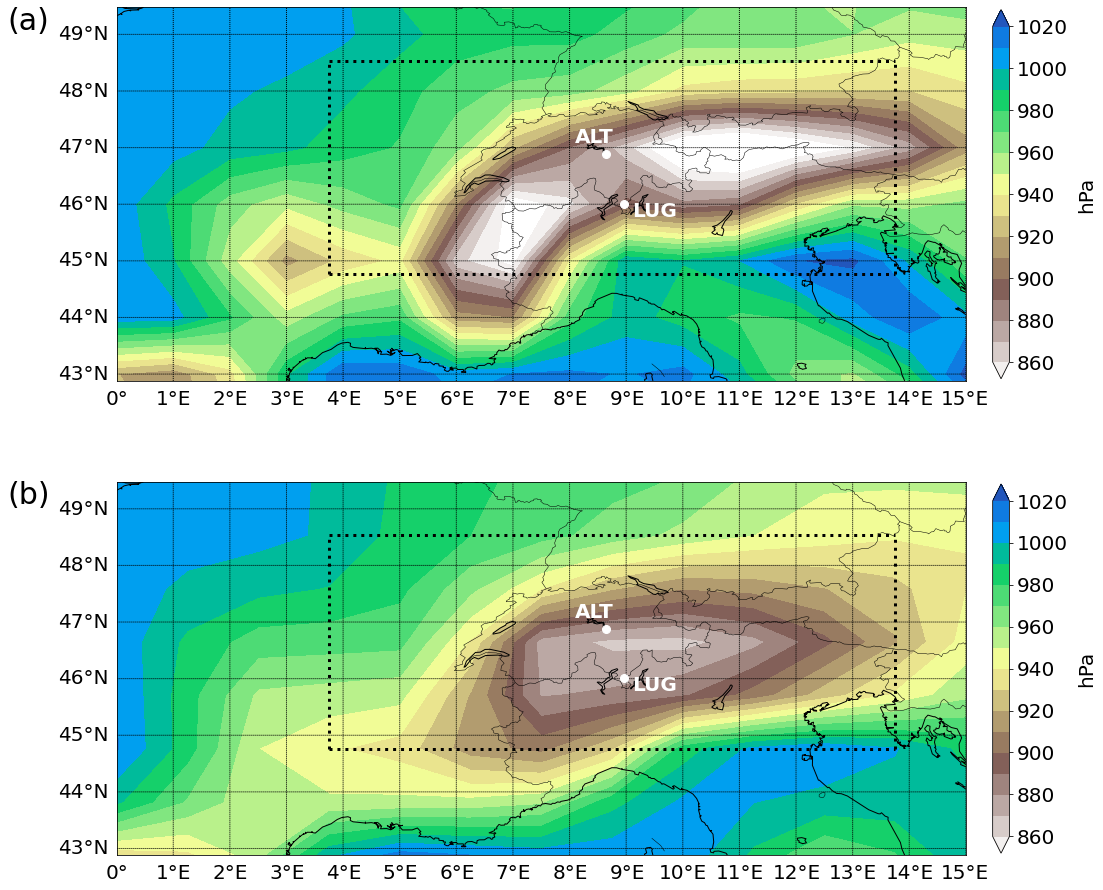

In [7]:
# Make large figure
fig = plt.figure(figsize=(16,2*8))

# Add ERAI topography
fig.add_subplot(211)
fig.text(0.03,0.851, "(a)", size=30, ha="left")  # Set label
make_mapfigure(PS_ERA, LONS_ERA, LATS_ERA)

# Add CESM topography
fig.add_subplot(212)
fig.text(0.03,0.44, "(b)", size=30, ha="left")
make_mapfigure(PS_CESM, LONS_CESM, LATS_CESM)

# Save figure
plt.savefig(os.path.join(BASE_DIR, "figures/ERAI_CESM_topography.pdf"), bbox_inches='tight', dpi=200)
print(f"Saved figure at: {os.path.join(BASE_DIR, 'figures/ERAI_CESM_topography.pdf')}")